In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

# Commonly used modules
import warnings
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib
import matplotlib.animation as animation
from IPython.display import HTML
import textwrap
import statsmodels.formula.api as smf

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler



warnings.filterwarnings("ignore")

In [3]:
# Load in the cleaned/normalized dataset

combined_data = pd.read_csv("/content/drive/MyDrive/ENEE408N/Sleep Analysis Research/DATA_SETS/test2.csv")
combined_data.head()

count    80190.000000
mean         1.960057
std          1.320244
min          0.000000
25%          0.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: Sleep_Stage, dtype: float64


In [4]:
#get x and y/training and testing

X = combined_data.drop("Sleep_Stage", axis=1).drop("sid", axis=1)
y = combined_data["Sleep_Stage"]

#split data into test and training data
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1)

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
train_features = (x_train - train_mean) / train_std

In [5]:
#implement 1 hot for 0-4 classifying
def one_hot(input):
  input = input.astype(int)
  arr = np.eye(6)[input]
  return arr


#use 1 hot func
y_true = y_test.copy()
y_train = one_hot(y_train)
y_test = one_hot(y_test)
print(y_train.shape)
print(y_test.shape)

print(y_train[0])

(72171, 6)
(8019, 6)
[0. 0. 0. 1. 0. 0.]


In [7]:
#Build
def reverse_one_hot(input):
  arr = np.argmax(input, axis=1)
  return arr

#class to pass through for Cohen Kappa Calculation
class Cohen_Kappa_Callback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(x_test, verbose=0)
        print(y_pred.shape)
        prediction = []
        index = 0
        max = 0
        for i in range(len(y_pred)):
          for j in range(5):
            if y_pred[i][j]>max:
              max = y_pred[i][j]
              index = j
          prediction.append(index)
          max = 0
        prediction = np.array(prediction)
        y2 = reverse_one_hot(y_test)

        print(prediction[:5])
        print(y2[:5])
        kappa = cohen_kappa_score(y2,prediction)

        print(f"Epoch {epoch + 1}: Cohen Kappa = {kappa:.4f}")




def build_model():
    model = keras.Sequential([
        Dense(134, activation=tf.nn.relu, input_shape=[x_train.shape[1]]),
        Dense(120, activation=tf.nn.relu),
        Dense(110, activation=tf.nn.relu),
        Dense(92, activation=tf.nn.relu),
        Dense(60, activation=tf.nn.relu),
        Dense(40, activation=tf.nn.relu),
        Dense(20, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense(6, activation=tf.nn.softmax)
    ])

    model.compile(optimizer=tf.optimizers.SGD(),
                  loss='categorical_crossentropy',
                  metrics=['mae', 'mse',"binary_accuracy", "f1_score"])
    return model


#Print to show progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 20 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(x_train, y_train, epochs=100, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot(), Cohen_Kappa_Callback()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch





.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 1: Cohen Kappa = 0.2479
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 2: Cohen Kappa = 0.2531
.(8019, 6)
[3 3 0 3 0]
[3 3 3 3 3]
Epoch 3: Cohen Kappa = 0.2720
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 4: Cohen Kappa = 0.2583
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 5: Cohen Kappa = 0.2775
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 6: Cohen Kappa = 0.2963
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 7: Cohen Kappa = 0.3130
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 8: Cohen Kappa = 0.2863
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 9: Cohen Kappa = 0.3292
.(8019, 6)
[3 3 3 3 3]
[3 3 3 3 3]
Epoch 10: Cohen Kappa = 0.3861


KeyboardInterrupt: 

In [ ]:
#Save model
model.save('/content/drive/MyDrive/my_model.h5')

NameError: name 'model' is not defined

In [8]:
from tensorflow import keras

# Load the model with custom_objects
model2 = keras.models.load_model('/content/drive/MyDrive/my_model.h5', custom_objects={'softmax_v2': tf.nn.softmax})

In [9]:
#Function for retrieving patient data
def get_text(SID):
  people = pd.read_csv("/content/drive/MyDrive/ENEE408N/Sleep Analysis Research/DATA_SETS/DREAMT_FE-master/DREAMT_FE-master/dataset_sample/participant_info.csv")
  person = people[people['SID'] == SID]
  text = ["Patient Demographics:\n"]
  text.append(f"Age: {int(person['AGE'].values[0])}")
  text.append(f"Gender: {person['GENDER'].values[0]}")
  conditions = f"Conditions: {person['MEDICAL_HISTORY'].values[0]}"
  if (len(conditions) <=25):
    text.append(conditions)
  else:
    wrapped = textwrap.wrap(conditions, 25)
    for line in wrapped:
      text.append(line)
  return text

In [12]:
#Function for actve demo


#32 33 37 93 97
def plot_patient(patient_num):


  patient = combined_data[combined_data["sid"] == patient_num]
  print(patient.shape)

  prediction_odds = model2.predict(patient.drop("Sleep_Stage", axis=1).drop("sid", axis=1))
  print(prediction_odds.shape)



  #GET MAX PRED
  prediction = []
  index = 0
  max = 0
  for i in range(len(prediction_odds)):
    for j in range(5):
      if prediction_odds[i][j]>max:
        max = prediction_odds[i][j]
        index = j
    prediction.append(index)
    max = 0


#GET DOWNSAMPLE ARRAYS
  downsampled_real = []
  downsampled_pred = []
  size = 16

  a = len(patient)-(len(patient)%size)
  print(a)
  sample1 = 0
  sample2 = 0
  for x in range(len(patient)):
    if x%size == 0:
      sample1 = prediction[x]
      sample2 = patient['Sleep_Stage'].iloc[x]
    downsampled_pred.append(sample1)
    downsampled_real.append(sample2)

  #GATHER METRICS
  freq1 = [0,0,0,0,0,0]
  freq2 = [0,0,0,0,0,0]
  for i in range(len(prediction)):
    freq1[prediction[i]] += 1
    freq2[patient['Sleep_Stage'].iloc[i]] += 1




  #GRAPH
  stages = {0: "Wake",
            1: "REM",
            2: "N1",
            3: "N2",
            4: "N3",
            5: ""}

  x = np.arange(0, len(downsampled_real))/2




  # GRAPH
  total_duration_minutes = len(downsampled_pred) * 30 / 60
  x = np.arange(0, total_duration_minutes, .5)
  stages = {0: "Wake", 1: "REM", 2: "N1", 3: "N2", 4: "N3"}

  # COLORMAP
  norm = plt.Normalize(0, 5)
  cmap = cm.get_cmap('Blues')

  #init fig
  fig = plt.figure(figsize=(10, 8))

  #init ax's
  ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
  ax2 = plt.subplot2grid((2, 3), (1, 0))
  ax3 = plt.subplot2grid((2, 3), (1, 1))
  ax4 = plt.subplot2grid((2, 3), (1, 2))


  fig.patch.set_facecolor('#121324')  # Set figure background color to black


  #AX1
  ax1.set_facecolor('#121324')  # Set axes background color to black
  line, = ax1.plot([], [], color=cmap(norm(downsampled_pred[0])), linewidth=4)
  line_segments = LineCollection([], cmap=cmap, norm=norm, linewidth=5)


  for i in range(len(downsampled_pred) - 1):
      color = cmap(norm(downsampled_pred[i]))
      ax1.plot([x[i], x[i+1]], [downsampled_pred[i], downsampled_pred[i+1]], color=color, linewidth=4)

  ax1.set_xlabel("Time (Minutes)", fontsize=16, color='white')  # Set x-axis label with white color
  ax1.set_ylabel("Sleep Stage", fontsize=16, color='white')  # Set y-axis label with white color
  ax1.set_title(f"Patient {patient_num} Night of Sleep ", fontsize=20, color='white')  # Set title with white color
  ax1.grid(True, color='gray')  # Set grid color to gray
  ax1.set_yticks(list(stages.keys()))  # Set y-axis tick locations
  ax1.set_yticklabels(list(stages.values()), color='white')  # Set y-axis tick labels with white color

  tick_interval_minutes = 30  # Set the desired interval for ticks in minutes
  xticks = np.arange(0, total_duration_minutes, tick_interval_minutes)
  ax1.set_xticks(xticks)
  ax1.set_xticklabels(xticks.astype(int), color='white')  # Convert to integers for labels

  ax1.invert_yaxis()

  sleep_stage_labels = list(stages.values())
  predicted_frequencies = [freq1[i] for i in range(len(sleep_stage_labels))]
  real_frequencies = [freq2[i] for i in range(len(sleep_stage_labels))]


  #Pred pie
  ax2.pie(predicted_frequencies, labels=sleep_stage_labels, autopct='%1.1f%%', startangle=90, colors=['#f7fbff', '#d0e1f2', '#94c4df', '#4a98c9', '#1764ab'], textprops={'color': 'white'})
  ax2.set_title("Predicted Sleep Stage Distribution", color='white', fontsize=10)

  #Real pie
  ax3.pie(real_frequencies, labels=sleep_stage_labels, autopct='%1.1f%%', startangle=90, colors=['#f7fbff', '#d0e1f2', '#94c4df', '#4a98c9', '#1764ab'], textprops={'color': 'white'})
  ax3.set_title("Ground Truth Sleep Stage Distribution", color='white', fontsize=10)

  # Set percentage text color to black
  for text in ax2.texts:
      if text.get_text().endswith('%'):
          text.set_color('black')
  for text in ax3.texts:
      if text.get_text().endswith('%'):
          text.set_color('black')


  #GET TEXT
  text = get_text(patient_num)

  #AX4
  ax4.text(0.5, 0.5, '\n'.join(text), fontsize=14, ha='center', va='center', color='white', bbox=dict(facecolor='#121324', alpha=0.5))
  ax4.patch.set_facecolor('#121324')
  ax4.set_facecolor('#121324')
  ax4.set_axis_off()

  fig.patch.set_facecolor('#121324')



  plt.tight_layout()
  plt.show()


(851, 134)
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
(851, 6)
848


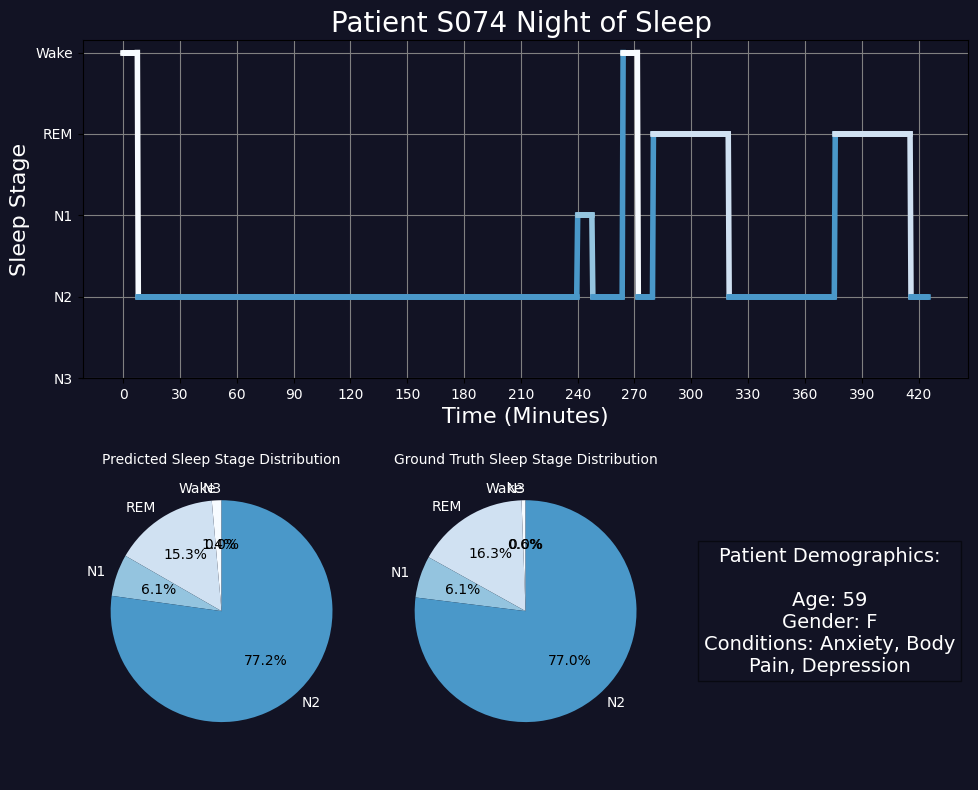

In [13]:
plot_patient("S074")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
(716, 6)
704


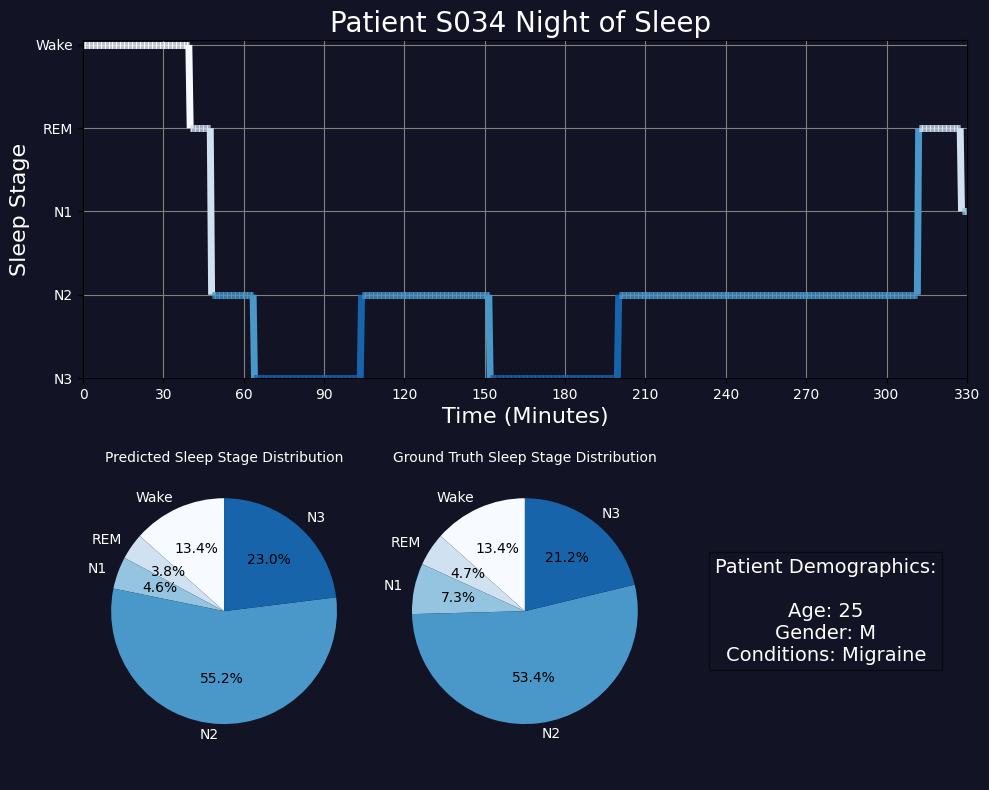

In [14]:
#Get Animation

patient_num = "S034"


patient = combined_data[combined_data["sid"] == patient_num]

prediction_odds = model2.predict(patient.drop("Sleep_Stage", axis=1).drop("sid", axis=1))
print(prediction_odds.shape)



#GET MAX PRED
prediction = []
index = 0
max = 0
for i in range(len(prediction_odds)):
  for j in range(5):
    if prediction_odds[i][j]>max:
      max = prediction_odds[i][j]
      index = j
  prediction.append(index)
  max = 0


#GET DOWNSAMPLE ARRAYS
downsampled_real = []
downsampled_pred = []
size = 16

a = len(patient)-(len(patient)%size)
print(a)
sample1 = 0
sample2 = 0
for x in range(len(patient)):
  if x%size == 0:
    sample1 = prediction[x]
    sample2 = patient['Sleep_Stage'].iloc[x]
  downsampled_pred.append(sample1)
  downsampled_real.append(sample2)

  #GATHER METRICS
freq1 = [0,0,0,0,0,0]
freq2 = [0,0,0,0,0,0]
for i in range(len(prediction)):
  freq1[prediction[i]] += 1
  freq2[patient['Sleep_Stage'].iloc[i]] += 1



  #GRAPH
x = np.arange(0, len(downsampled_real))/2






# GRAPH
total_duration_minutes = len(downsampled_pred) * 30 / 60
x = np.arange(0, total_duration_minutes, .5)
stages = {0: "Wake", 1: "REM", 2: "N1", 3: "N2", 4: "N3"}

# COLORMAP
norm = plt.Normalize(0, 5)
cmap = cm.get_cmap('Blues')

#INIT FIG
fig = plt.figure(figsize=(10, 8))

#INIT AX's
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (1, 1))
ax4 = plt.subplot2grid((2, 3), (1, 2))

fig.patch.set_facecolor('#121324')  # Set figure background color to black


#AX1
ax1.set_facecolor('#121324')  # Set axes background color to black
line, = ax1.plot([], [], color=cmap(norm(downsampled_pred[0])), linewidth=4)
line_segments = LineCollection([], cmap=cmap, norm=norm, linewidth=5)
ax1.add_collection(line_segments)

# Animation function
def animate(i):
    x_data = x[:i+2]
    y_data = downsampled_pred[:i+2]

    # Create segments
    points = np.array([x_data, y_data]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Update LineCollection
    line_segments.set_segments(segments)
    line_segments.set_array(y_data[:-1])

    return line_segments,



# Create animation
ani = animation.FuncAnimation(fig, animate, frames=len(downsampled_pred),
                              interval=35, blit=True, repeat=False)

ax1.set_xlabel("Time (Minutes)", fontsize=16, color='white')
ax1.set_ylabel("Sleep Stage", fontsize=16, color='white')
ax1.set_title(f"Patient {patient_num} Night of Sleep ", fontsize=20, color='white')
ax1.grid(True, color='gray')
ax1.set_yticks(list(stages.keys()))
ax1.set_yticklabels(list(stages.values()), color='white')

tick_interval_minutes = 30
xticks = np.arange(0, total_duration_minutes, tick_interval_minutes)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks.astype(int), color='white')

ax1.invert_yaxis()


#PREDICTIONS
sleep_stage_labels = list(stages.values())
predicted_frequencies = [freq1[i] for i in range(len(sleep_stage_labels))]
real_frequencies = [freq2[i] for i in range(len(sleep_stage_labels))]


#Pred pie
ax2.pie(predicted_frequencies, labels=sleep_stage_labels, autopct='%1.1f%%', startangle=90, colors=['#f7fbff', '#d0e1f2', '#94c4df', '#4a98c9', '#1764ab'], textprops={'color': 'white'})
ax2.set_title("Predicted Sleep Stage Distribution", color='white', fontsize=10)

#Real pie
ax3.pie(real_frequencies, labels=sleep_stage_labels, autopct='%1.1f%%', startangle=90, colors=['#f7fbff', '#d0e1f2', '#94c4df', '#4a98c9', '#1764ab'], textprops={'color': 'white'})
ax3.set_title("Ground Truth Sleep Stage Distribution", color='white', fontsize=10)

# Set percentage text color to black
for text in ax2.texts:
    if text.get_text().endswith('%'):
        text.set_color('black')
for text in ax3.texts:
    if text.get_text().endswith('%'):
        text.set_color('black')

#GET TEXT
text = get_text(patient_num)


ax4.text(0.5, 0.5, '\n'.join(text), fontsize=14, ha='center', va='center', color='white', bbox=dict(facecolor='#121324', alpha=0.5))
ax4.patch.set_facecolor('#121324')
ax4.set_facecolor('#121324')
ax4.set_axis_off()

fig.patch.set_facecolor('#121324')



plt.tight_layout()
#plt.show()
HTML(ani.to_html5_video())

In [15]:
#Gather importamt metrics
#THIS IS RUN AFTER A TRAINING RUN

test_features_norm = (x_test - train_mean) / train_std
loss, mae, mse, accuracy, f1_score = model.evaluate(test_features_norm, y_test)

rmse_final = np.sqrt(float(hist['val_mse'].iloc[-1]))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


#Plot MSE
def plot_mse():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_mse()

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8548 - f1_score: 0.3256 - loss: 1.5434 - mae: 0.1637 - mse: 0.1096


NameError: name 'hist' is not defined

0     0.856297
1     0.855362
2     0.862765
3     0.862921
4     0.867726
        ...   
95    0.904328
96    0.903211
97    0.890586
98    0.905263
99    0.901808
Name: val_binary_accuracy, Length: 100, dtype: float64


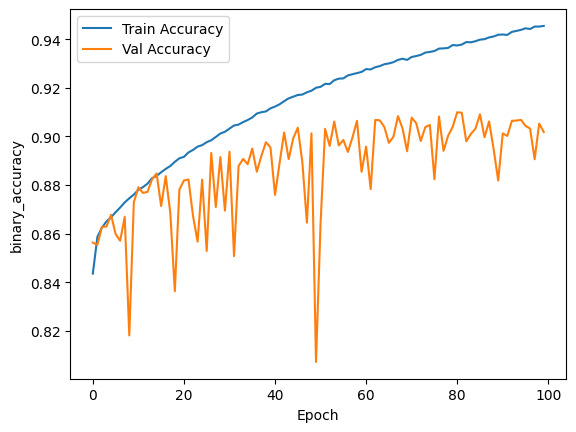

In [ ]:
#Binary accuracy
def plot_accuracy():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('binary_accuracy')
    plt.plot(hist['epoch'], hist['binary_accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_binary_accuracy'], label = 'Val Accuracy')
    plt.legend()

plot_accuracy()

0     (tf.Tensor(0.49222392, shape=(), dtype=float32...
1     (tf.Tensor(0.43454543, shape=(), dtype=float32...
2     (tf.Tensor(0.59891105, shape=(), dtype=float32...
3     (tf.Tensor(0.51949114, shape=(), dtype=float32...
4     (tf.Tensor(0.60217315, shape=(), dtype=float32...
                            ...                        
95    (tf.Tensor(0.7456403, shape=(), dtype=float32)...
96    (tf.Tensor(0.74650073, shape=(), dtype=float32...
97    (tf.Tensor(0.7232532, shape=(), dtype=float32)...
98    (tf.Tensor(0.7368713, shape=(), dtype=float32)...
99    (tf.Tensor(0.72923934, shape=(), dtype=float32...
Name: val_f1_score, Length: 100, dtype: object


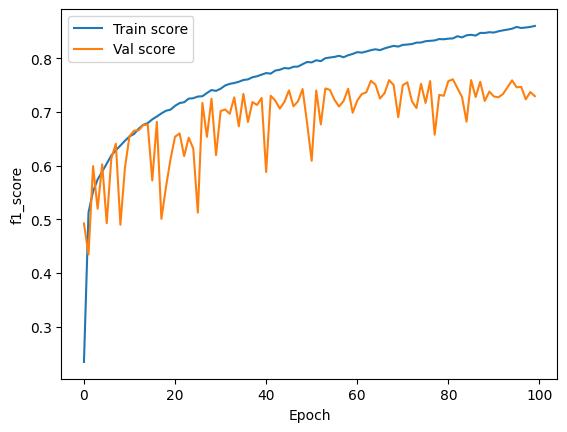

In [ ]:
#Plot F1_Score
def plot_f1():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('f1_score')
    plt.plot(hist['epoch'], [x[0] for x in hist['f1_score']], label='Train score')
    plt.plot(hist['epoch'], [x[0] for x in hist['val_f1_score']], label = 'Val score')
    plt.legend()

plot_f1()
